In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists

from clearml import Task, OutputModel

from amplify.data import DataGenerator, DataSplit

## Load Data

In [2]:
# DataGenerator - ClearML
xy_data = DataGenerator().load_data()
xy_data.shape

Info: Successfully loaded Building data!
Info: Successfully loaded Weather data!
Successfully merged Building and Weather data!
Successfully added Azimuth and Irradiance data!


(1994, 7)

## Data Processing

In [83]:
# ClearML Stuff
count = 0
task = Task.init(project_name="amplify", task_name="encoder-decoder-lstm", output_uri="s3://amplify-microgrid-ai")

In [84]:
# Data Split parameters 
SERIES = 48
STRIDE = 1

In [85]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)

# |0| |2|3| |5|6|7|8|9|
#    T     V 

# This is for solar only, for now
train_ds, val_ds, test_ds = DataSplit(xy_data, series_length=SERIES, stride=STRIDE).split_data()

Successfully split data into (train_x, train_y), (val_x, val_y), (test_x, test_y) tuples!


In [86]:
# Isolate XY from datasets
x_train, y_train,  = (
    train_ds[0],
    train_ds[1],
)  # Training data
x_val, y_val = (
    val_ds[0],
    val_ds[1],
)  # Validation data
x_test, y_test = (
    test_ds[0],
    test_ds[1],
)  # Test data


### Reviewing Data

In [87]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)


x_train shape:  (1547, 48, 5)
y_train shape:  (1547, 48, 2)


## Modeling

In [88]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, Normalization, TimeDistributed

### Normalize Data

## Encoder/Decoder LSTM

In [89]:
# Normalize to x_train data
norm_layer = Normalization(axis=-1)
norm_layer.adapt(x_train)

# Define the model 
norm_inputs = Input(shape=(SERIES, x_train.shape[-1]))
encoder_inputs = norm_layer(norm_inputs)
encoder_l1 = LSTM(10*SERIES, return_state=True, dropout=.25)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = RepeatVector(SERIES)(encoder_outputs1[0])

decoder_l1 = LSTM(10*SERIES, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
decoder_outputs1 = TimeDistributed(Dense(y_train.shape[-1], activation='relu'))(decoder_l1)

model = Model(norm_inputs, decoder_outputs1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 5)]      0           []                               
                                                                                                  
 normalization_2 (Normalization  (None, 48, 5)       11          ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 480),        933120      ['normalization_2[0][0]']        
                                 (None, 480),                                                     
                                 (None, 480)]                                               

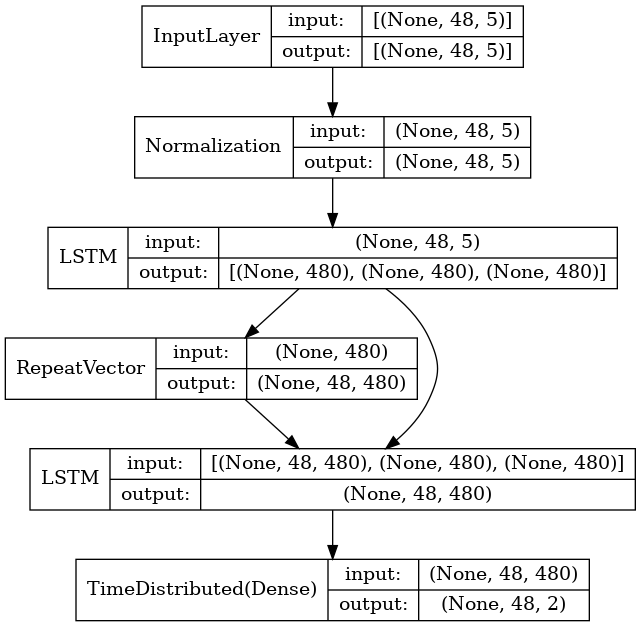

In [90]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [91]:
# Hyperparameters and callbacks

BATCH  = 7
EPOCHS = 100
FACTOR = .9
PATIENCE = 5
count += 1

log_dir = os.path.join('../','logs', str(count))
model_path = os.path.join('../', 'models', "lstm_weights.hdf5")

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        monitor="val_loss",
        mode='min',
        save_best_only=True, 
        save_weights_only=True, 
        
        verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', 
        mode='min', 
        factor=FACTOR,
        patience=PATIENCE, 
        min_lr=1e-8, 
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        mode='min', 
        patience=5*PATIENCE, 
        verbose=1)
]

In [92]:
# try:
#     model.load_weights(model_path)
# except Exception:
#     pass

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    #loss=tf.keras.losses.Huber(), # Less sensitive to outliers 
    loss=tf.keras.losses.MeanSquaredError(),  # More sensitive to outliers 
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/100
221/221 [==============================] - ETA: 0s - loss: 71.8878 - root_mean_squared_error: 8.4787
Epoch 00001: val_loss improved from inf to 39.33351, saving model to ../models/lstm_weights.hdf5
2022-01-31 23:32:12,468 - clearml.storage - INFO - Starting upload: /tmp/.clearml.upload_model_krl9uy5n.tmp => amplify-microgrid-ai/amplify/encoder-decoder-lstm.8f062e1c23c94895a8af0d2022cc6e3f/models/lstm_weights.hdf5
221/221 [==============================] - 8s 26ms/step - loss: 71.8878 - root_mean_squared_error: 8.4787 - val_loss: 39.3335 - val_root_mean_squared_error: 6.2716 - lr: 0.0010
Epoch 2/100
220/221 [============================>.] - ETA: 0s - loss: 63.3799 - root_mean_squared_error: 7.9611
Epoch 00002: val_loss improved from 39.33351 to 35.23119, saving model to ../models/lstm_weights.hdf5
2022-01-31 23:32:17,391 - clearml.storage - INFO - Uploading: 10.12MB / 10.62MB @ 2.04MBs from /tmp/.clearml.upload_model_krl9uy5n.tmp
221/221 [==============================] - 5

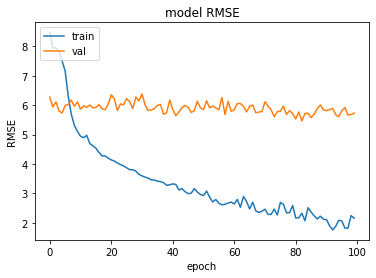

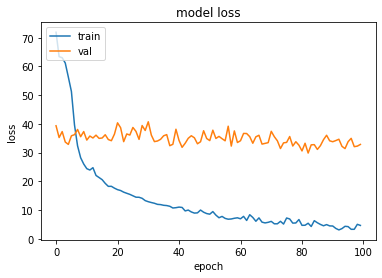

In [93]:
def plot_history(history, metric):
    # This function will plot the model fit process
    # summarize history for accuracy
    if metric == "root_mean_squared_error":
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_percentage_error":
        plt.plot(history.history["mean_absolute_percentage_error"])
        plt.plot(history.history["val_mean_absolute_percentage_error"])
        plt.title('model MAPE')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_error":
        plt.plot(history.history["mean_absolute_error"])
        plt.plot(history.history["val_mean_absolute_error"])
        plt.title('model MAE')
        plt.ylabel('MAE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history, 'root_mean_squared_error')

In [94]:
# scores with final weights
scores = model.evaluate(x_test, y_test, verbose=1, batch_size=BATCH, callbacks=callbacks)

22/22 [==============================] - 0s 13ms/step - loss: 34.6410 - root_mean_squared_error: 5.8857


In [97]:
# Evaluate and make predictions
model.load_weights(model_path)
scores = model.evaluate(x_test, y_test, verbose=1, batch_size=BATCH, callbacks=callbacks)
y_preds = model.predict(x_test, verbose=1, batch_size=BATCH, callbacks=callbacks)


22/22 [==============================] - 0s 5ms/step


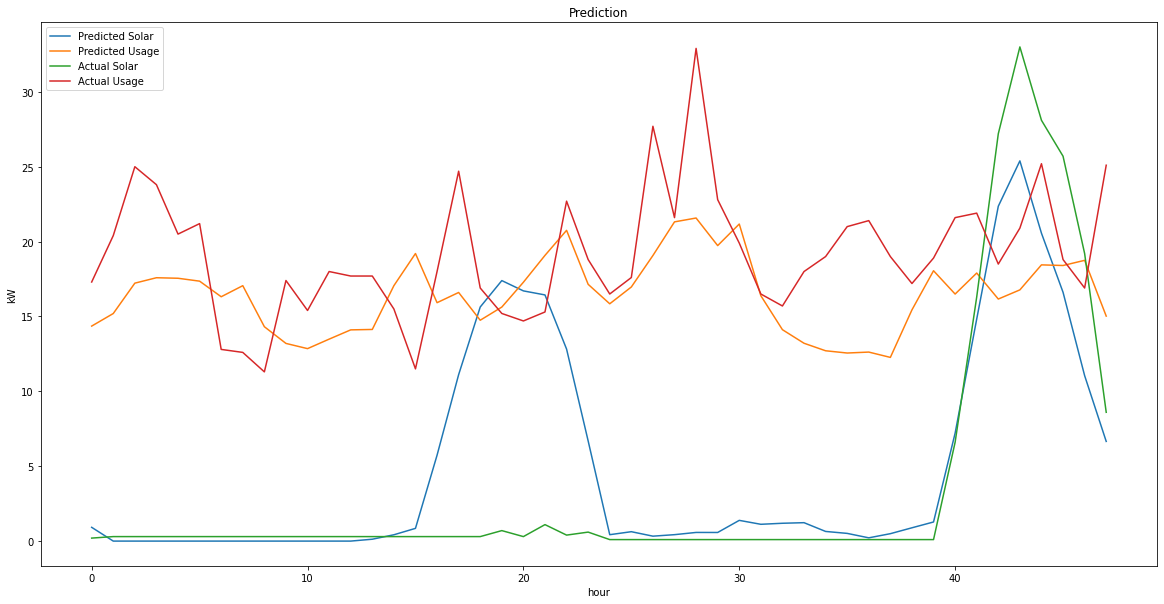

In [99]:
plt.figure(figsize=(20, 10))
plt.title('Prediction')
x = np.random.default_rng().integers(0, y_preds.shape[0])
plt.plot(y_preds[x,:,:])
plt.plot(y_test[x,:,:])
plt.ylabel('kW')
plt.xlabel('hour')
plt.legend(['Predicted Solar', 'Predicted Usage', 'Actual Solar', 'Actual Usage'], loc='upper left')

plt.show()